# **1. Carga de Datos**

In [23]:
# Se importa los paquetes necesarios
import pandas as pd
import requests
import zipfile, os, sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
#Cargar el dataset normalizado y preprocesado

url ="https://raw.githubusercontent.com/Nolhandm/Proyecto-Metodologias-Agiles-para-el-Desarrollo-de-Proyectos-con-Machine-Learning/refs/heads/master/data/ESG_ByInd_df_norm.csv"

ESG_ByInd_df_norm = pd.read_csv(url)
ESG_ByInd_df_norm

,Country Name,Access to clean fuels and technologies for cooking (% of population),Adjusted savings: natural resources depletion (% of GNI),Adjusted savings: net forest depletion (% of GNI),Agricultural land (% of land area),"Agriculture, forestry, and fishing, value added (% of GDP)","Annual freshwater withdrawals, total (% of internal resources)",CO2 emissions (metric tons per capita),Energy intensity level of primary energy (MJ/$2017 PPP GDP),Food production index (2014-2016 = 100),...,Proportion of seats held by women in national parliaments (%),Ratio of female to male labor force participation rate (%) (modeled ILO estimate),Renewable energy consumption (% of total final energy consumption),Rule of Law: Estimate,"School enrollment, primary (% gross)",Scientific and technical journal articles,Standardised Precipitation-Evapotranspiration Index,Terrestrial and marine protected areas (% of total territorial area),Tree Cover Loss (hectares),"Unemployment, total (% of total labor force) (modeled ILO estimate)"
0,Albania,0.859879,0.013981,0.008005,0.437871,0.336111,0.001795,0.083500,0.105519,0.322526,...,0.543326,0.739451,0.462764,0.414964,0.354728,0.000239,0.610397,0.253910,0.000564,0.385606
1,Algeria,0.996976,0.223213,0.000000,0.196559,0.270211,0.054861,0.177777,0.341721,0.377220,...,0.049623,0.060542,0.000000,0.231343,0.501182,0.008483,0.225517,0.078708,0.006843,0.427020
2,Argentina,0.998992,0.035810,0.000000,0.488086,0.119806,0.008086,0.198274,0.184253,0.360023,...,0.704866,0.654970,0.100927,0.328233,0.522019,0.014517,0.338507,0.171059,0.067476,0.235069
3,Armenia,0.987903,0.062930,0.015725,0.675811,0.173431,0.025948,0.118593,0.236201,0.120195,...,0.539744,0.789546,0.085720,0.414196,0.323633,0.000884,0.285825,0.442207,0.000002,0.289613
4,Australia,1.000000,0.108610,0.007093,0.543648,0.049270,0.001060,0.671220,0.257305,0.385490,...,0.591546,0.843511,0.111863,0.876532,0.404428,0.090906,0.684288,0.575544,0.087250,0.120693
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,United States,1.000000,0.014226,0.000000,0.530396,0.015353,0.009889,0.662881,0.251623,0.279861,...,0.417950,0.813461,0.114676,0.838415,0.385759,0.680638,0.562095,0.284525,0.683276,0.121757
110,Uruguay,1.000000,0.000336,0.000000,0.940370,0.112197,0.002455,0.106362,0.146104,0.251292,...,0.356230,0.725489,0.634726,0.672061,0.497122,0.001422,0.350763,0.043628,0.005682,0.289968
111,Uzbekistan,0.779234,0.243988,0.000000,0.669650,0.427465,0.227068,0.161092,0.521916,0.407387,...,0.500745,0.441252,0.009166,0.225384,0.338484,0.002042,0.017921,0.103224,0.000001,0.145818
112,Viet Nam,0.986895,0.008981,0.000000,0.450541,0.246542,0.014303,0.169309,0.238636,0.400056,...,0.445792,0.866875,0.197479,0.416985,0.671238,0.012252,0.572130,0.052352,0.064532,0.050995


In [25]:
X = ESG_ByInd_df_norm.drop(columns=['Country Name'])

# **2. Kmeans**

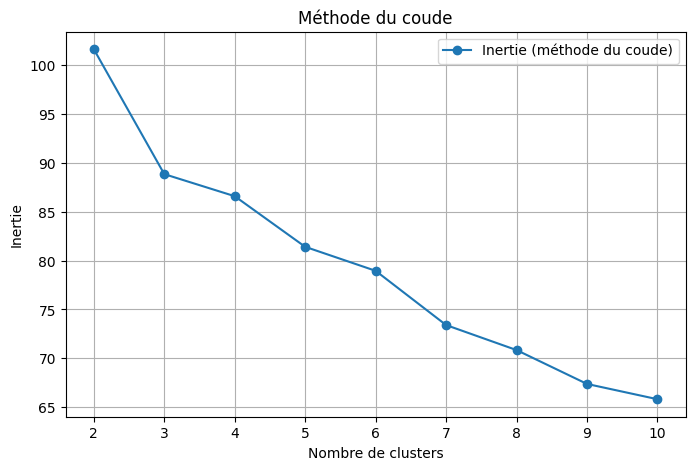

In [26]:
from sklearn.cluster import KMeans

inertia = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(k_range, inertia, 'o-', label="Inertie (méthode du coude)")
plt.xlabel("Nombre de clusters")
plt.ylabel("Inertie")
plt.title("Méthode du coude")
plt.grid(True)
plt.legend()
plt.show()

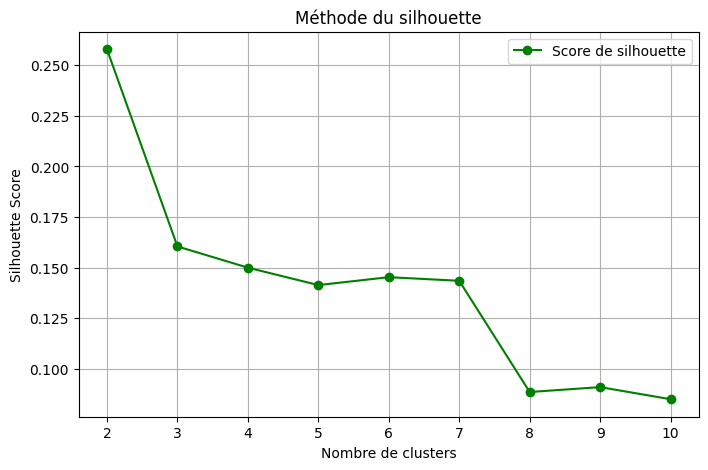

In [27]:
from sklearn.metrics import silhouette_score

silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(8,5))
plt.plot(k_range, silhouette_scores, 'o-', color='green', label="Score de silhouette")
plt.xlabel("Nombre de clusters")
plt.ylabel("Silhouette Score")
plt.title("Méthode du silhouette")
plt.grid(True)
plt.legend()
plt.show()

In [28]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X)

# Ajout au DataFrame original
ESG_ByInd_df_norm["cluster"] = clusters

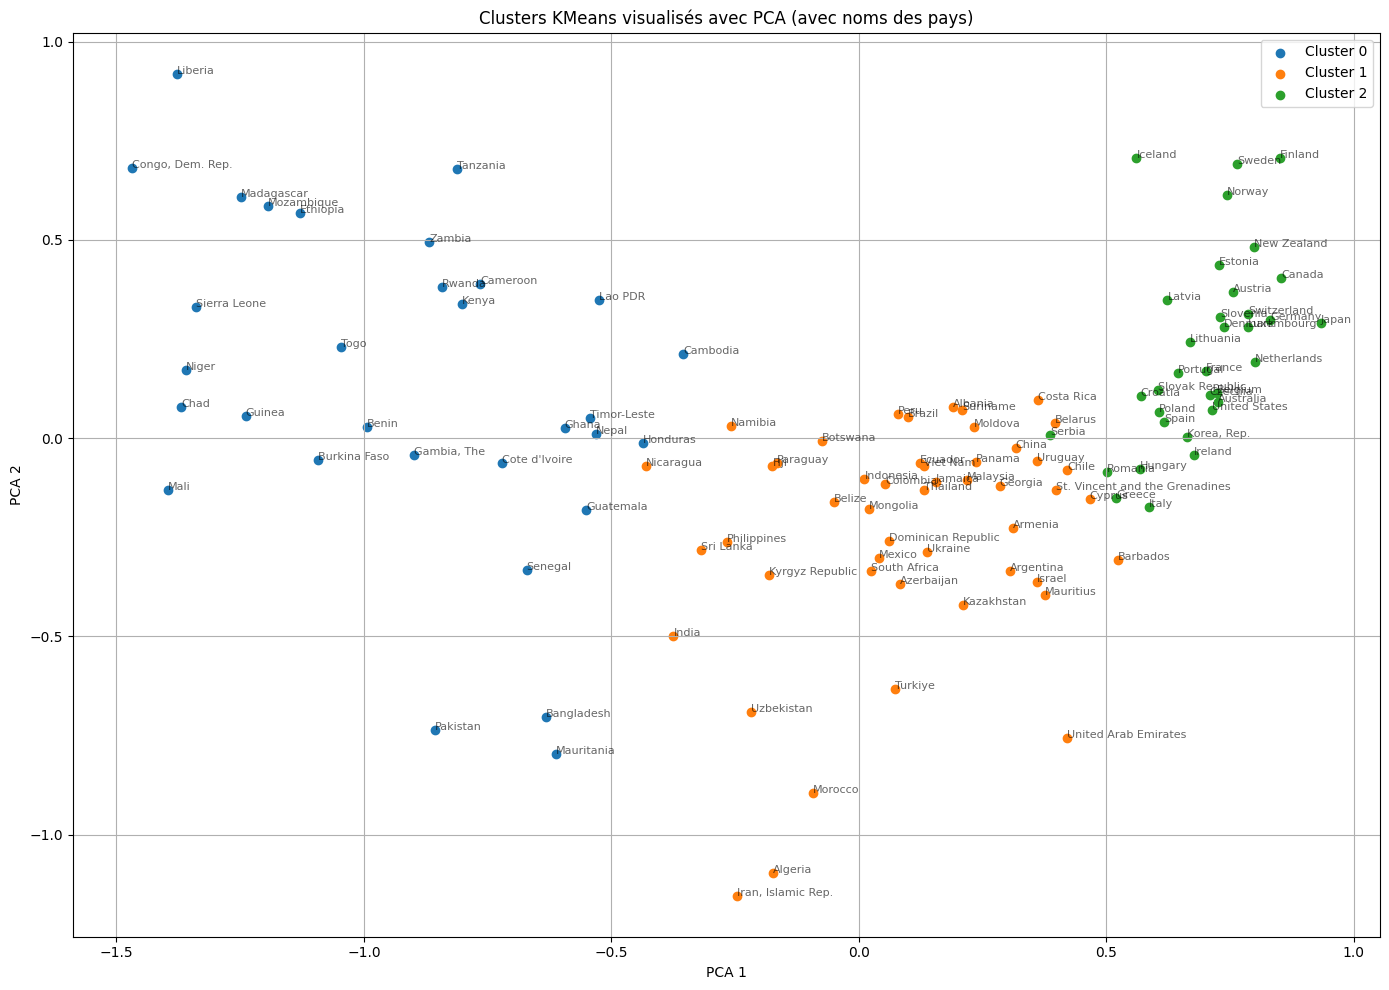

In [30]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Visualisation
plt.figure(figsize=(14, 10))

for i in range(k):
    plt.scatter(
        X_pca[clusters == i, 0],
        X_pca[clusters == i, 1],
        label=f"Cluster {i}"
    )

# Ajouter les noms des pays
for i, country in enumerate(ESG_ByInd_df_norm['Country Name']):  # Remplace X.index si les noms sont dans une colonne
    plt.text(X_pca[i, 0], X_pca[i, 1], country, fontsize=8, alpha=0.6)

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Clusters KMeans visualisés avec PCA (avec noms des pays)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# **3. Self Organizing Map(SOM)**

In [31]:
pip install minisom

  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.5-py3-none-any.whl size=12031 sha256=bc4f11b2d6f96d639b3da92351228db44a1c636b6e1b165859cd2d967ccb1556
  Stored in directory: /root/.cache/pip/wheels/19/db/95/5e53bc2b88a328217fdf9f2886cafbe86b0df274f4b601f572
Successfully built minisom


In [38]:
from minisom import MiniSom

som_size = 10
som = MiniSom(x=som_size, y=som_size, input_len=X.shape[1], sigma=1.0, learning_rate=0.5)
som.random_weights_init(X.values) # Convert DataFrame to NumPy array
som.train(X.values, num_iteration=1000) # Convert DataFrame to NumPy array

weights = som.get_weights().reshape(-1, X.shape[1])

best_k = 3
final_kmeans = KMeans(n_clusters=best_k, random_state=0).fit(weights)
som_clusters = final_kmeans.predict(weights)

In [39]:
bmu_indices = np.array([som.winner(x) for x in X.to_numpy()])
bmu_flat_indices = [pos[0]*som_size + pos[1] for pos in bmu_indices]
ESG_ByInd_df_norm['cluster SOM'] = [som_clusters[i] for i in bmu_flat_indices]

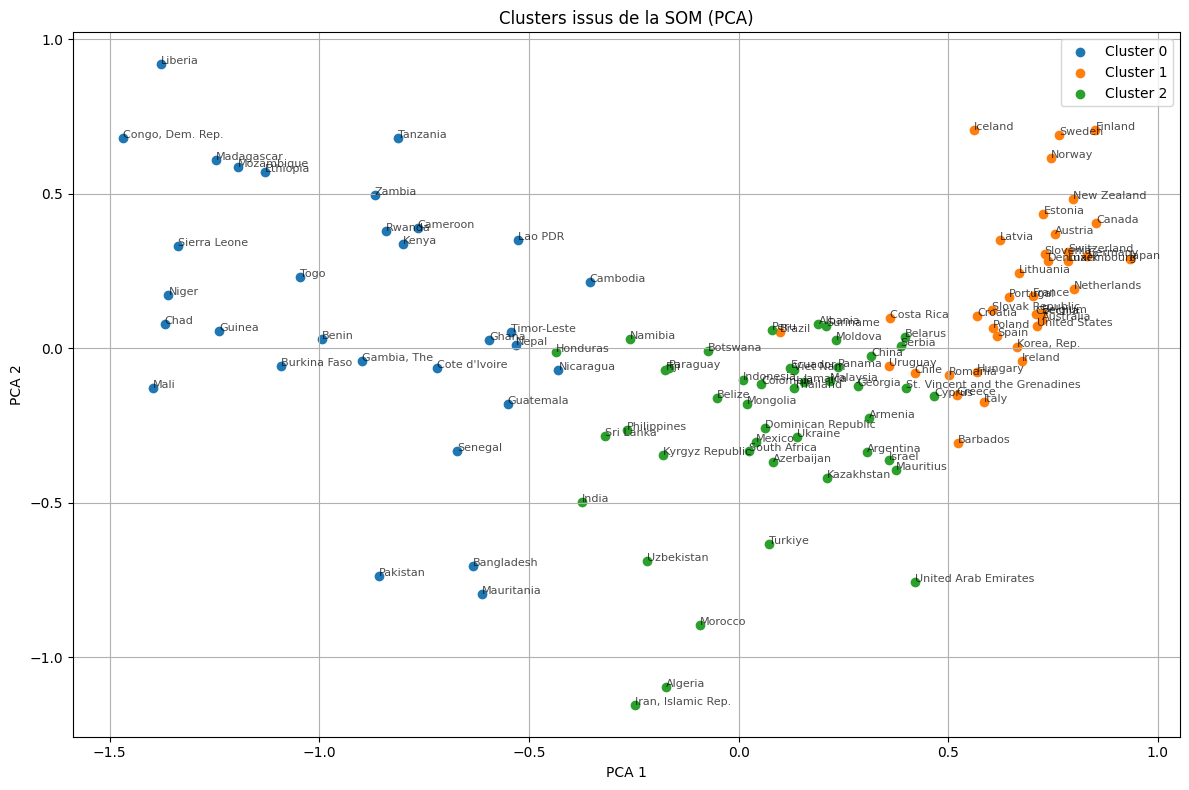

In [40]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(12, 8))
for cluster_id in range(best_k):
    indices = ESG_ByInd_df_norm['cluster SOM'] == cluster_id
    plt.scatter(X_pca[indices, 0], X_pca[indices, 1], label=f'Cluster {cluster_id}')

# Ajouter les noms des pays
for i, txt in enumerate(ESG_ByInd_df_norm['Country Name']):
    plt.annotate(txt, (X_pca[i, 0], X_pca[i, 1]), fontsize=8, alpha=0.7)

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Clusters issus de la SOM (PCA)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

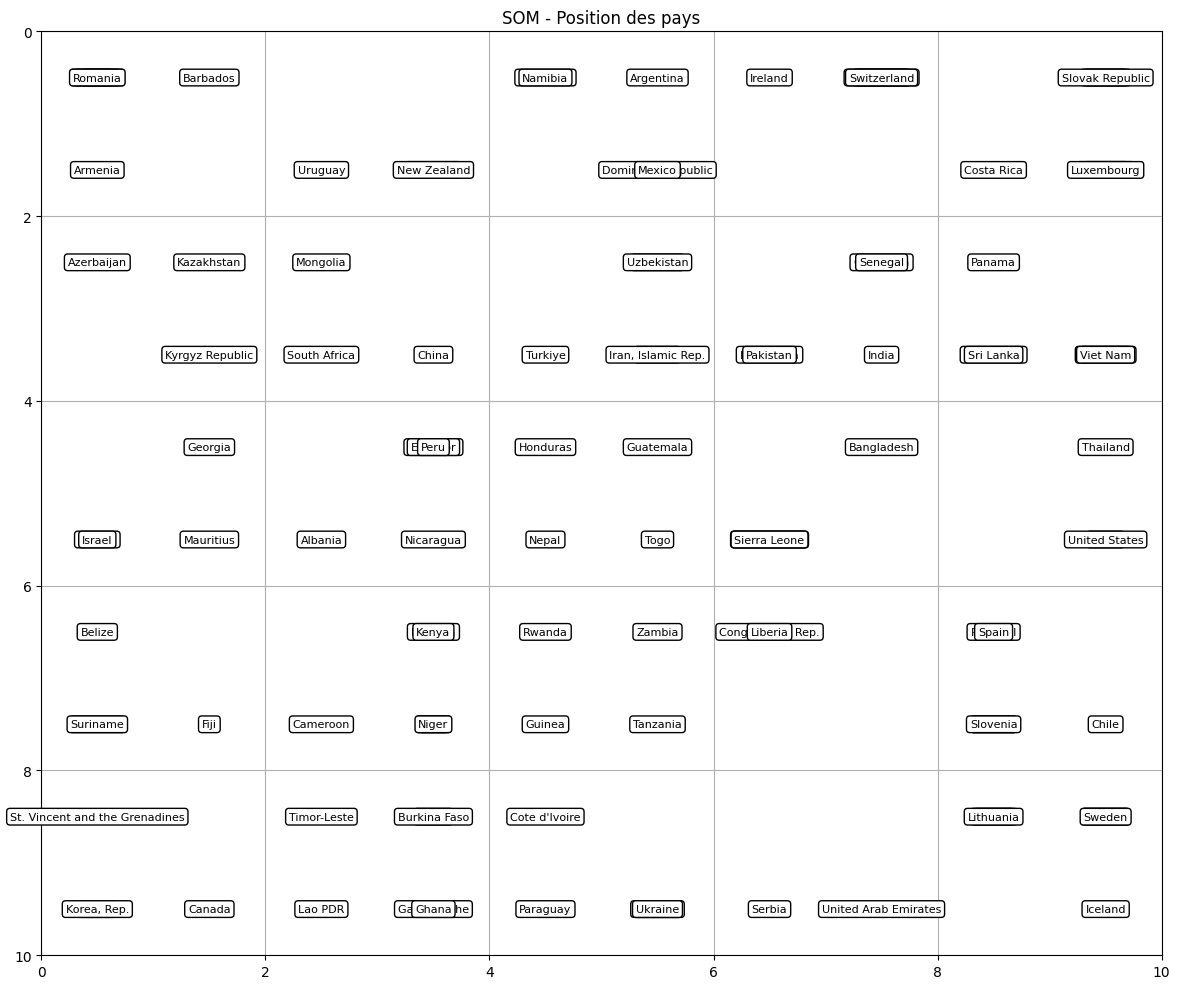

In [45]:
def plot_som_with_labels(som, data, labels, figsize=(12, 10)):
    plt.figure(figsize=figsize)
    plt.title("SOM - Position des pays")

    # Affiche la grille de la SOM
    for i, x in enumerate(data):
        w = som.winner(x)  # Coordonnées du BMU (Best Matching Unit)
        plt.text(
            w[0] + 0.5, w[1] + 0.5, labels[i],
            ha='center', va='center',
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'),
            fontsize=8
        )

    plt.xlim([0, som._weights.shape[0]])
    plt.ylim([0, som._weights.shape[1]])
    plt.gca().invert_yaxis()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_som_with_labels(som, X.to_numpy(), ESG_ByInd_df_norm["Country Name"].values)

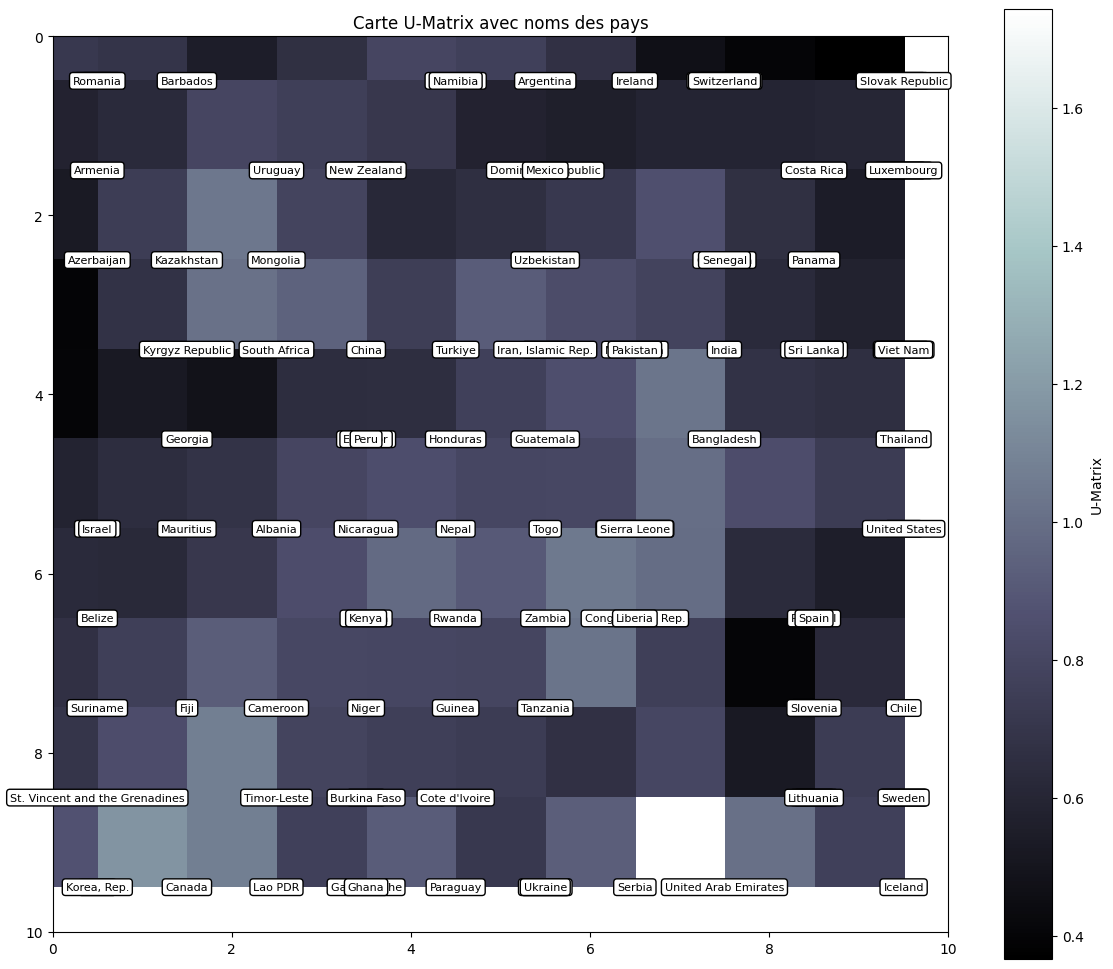

In [47]:
def plot_u_matrix_with_labels(som, data, labels, figsize=(12, 10)):
    from numpy.linalg import norm

    weights = som.get_weights()
    umatrix = np.zeros((som._weights.shape[0], som._weights.shape[1]))

    for x in range(som._weights.shape[0]):
        for y in range(som._weights.shape[1]):
            neighbors = []
            if x > 0:
                neighbors.append(weights[x - 1, y])
            if x < som._weights.shape[0] - 1:
                neighbors.append(weights[x + 1, y])
            if y > 0:
                neighbors.append(weights[x, y - 1])
            if y < som._weights.shape[1] - 1:
                neighbors.append(weights[x, y + 1])
            dist = np.mean([norm(weights[x, y] - n) for n in neighbors])
            umatrix[x, y] = dist

    plt.figure(figsize=figsize)
    plt.imshow(umatrix.T, origin='lower', cmap='bone')
    plt.colorbar(label='U-Matrix')
    plt.title("Carte U-Matrix avec noms des pays")

    for i, x in enumerate(data):
        w = som.winner(x)
        plt.text(
            w[0] + 0.5, w[1] + 0.5, labels[i],
            ha='center', va='center',
            fontsize=8,
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3')
        )

    plt.xlim([0, som._weights.shape[0]])
    plt.ylim([0, som._weights.shape[1]])
    plt.gca().invert_yaxis()
    plt.grid(False)
    plt.tight_layout()
    plt.show()

plot_u_matrix_with_labels(som, X.to_numpy(), ESG_ByInd_df_norm["Country Name"].values)

In [48]:
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

ch_score = calinski_harabasz_score(X, ESG_ByInd_df_norm['cluster SOM'])
db_score = davies_bouldin_score(X, ESG_ByInd_df_norm['cluster SOM'])

print(f"Calinski-Harabasz Score : {ch_score:.2f}")
print(f"Davies-Bouldin Score : {db_score:.2f}")

Calinski-Harabasz Score : 30.41
Davies-Bouldin Score : 1.89
